<div align="right"><h5>Бронников Максим Андреевич</h5></div>

<div align="right"><h5>группа: M8О-407Б-17, №4 по списку</h5></div>

<h1><center>Лабораторная работа №8</center></h1>

***Задание:*** Используя схемы *переменных направлений* и *дробных шагов*, решить двумерную начально-краевую задачу для дифференциального *уравнения параболического типа*. В различные моменты времени вычислить погрешность численного решения путем сравнения результатов с приведенным в задании аналитическим решением $u(x, y, t)$. Исследовать зависимость погрешности от сеточных параметров $\tau$ и $h_x$, $h_y$.

### <center> Вариант №4 </center>

In [4]:
import ipywidgets as widgets
from ipywidgets import interact
from IPython.display import display
import random
import matplotlib.pyplot as plt
import math
import sys
import warnings
import numpy as np
import glob
import moviepy.editor as mpy
from functools import reduce
from mpl_toolkits.mplot3d import Axes3D

***Уравнение:***

$$\displaystyle\frac{\partial u}{\partial t} =  a\displaystyle\frac{\partial^2 u}{\partial x^2} + a\displaystyle\frac{\partial^2 u}{\partial y^2}, \; a >  0$$

***Граничные условия:***

\begin{equation*}
 \begin{cases}
   u (0, y, \: t) = \phi_0(y, t) = \cosh{y} \cdot e^{-3at}
   \\
   u (\frac{\pi}{4}, y, \: t) = \phi_1(y, t) = 0
   \\
   u (x, 0, \: t) = \psi_0(x, t) = \cos{2x} \cdot e^{-3at}
   \\
   u_{y}' (x, \ln{2}, \: t) = \psi_1(x, t) = \frac{3}{4} \cos{2x} \cdot e^{-3at}
   \\
   u(x, y, 0) = u^0 (x, y) = cos{2x} \cosh{y}
 \end{cases}
\end{equation*}

***Аналитическое решение:***
$$u(x, y, t) = e^{-3at} \cos{2x} \cosh{y}$$

In [5]:
def psi_0(x, t, a = 1):
    return math.cos(2*x) * math.exp(-3*a*t)

# need to approx
def psi_1(x, t, a = 1):
    return 3*math.cos(2*x)*math.exp(-3*a*t) / 4

def phi_0(y, t, a = 1):
    return math.cosh(y) * math.exp(-3*a*t)

def phi_1(y, t, a = 1):
    return 0

def u0(x, y, a = 1):
    return math.cos(2*x) * math.cosh(y)

# analytic solve
def u(x, y, t, a = 1):
    return math.cos(2*x) * math.cosh(y) * math.exp(-3*a*t)

## <center> Конечно-разностная схема </center>

<h3><center> Общая концепция </center></h3>

Будем решать задачу на заданной площади  от $0$ до $l_x$ по координате $x$, от $0$ до $l_y$ по координате $y$ и на промежутке от $0$ до заданного параметра $T$ по времени $t$.

Рассмотрим конечно-разностную схему решения краевой задачи на сетке с граничными парамерами $l_x$, $l_y$, $T$ и параметрами насыщенности сетки $N_x$, $N_y$, $K$. Тогда размер шага по каждой из координат определяется:
$$h_x = \displaystyle\frac{l_x}{N_x -1}, \; h_y = \displaystyle\frac{l_y}{N_y -1} , \; \tau = \displaystyle\frac{T}{K-1}$$


Конечно-разностная схема решения параболического типа в сетке на временном слое $t^{k+1}$ определяется с помощью 2-ух этапов, на каждом из которых решается трёхдиагональное уравнение с помощью метода прогонки:
- Считая, что значения функции $u^k_{i, j} = u(x_i, y_j, t^k)$ на временном слое $t^{k}$ известно, попробуем определить значения функции на временном слое $t^{k + \frac{1}{2}}$ путем разностной апроксимации производной по времени:$\displaystyle\frac{\partial u}{\partial t}(x_i, y_j, t^k) = 2\displaystyle\frac{u^{k+\frac{1}{2}}_{i, j} - u^{k}_{i, j}}{\tau}$, неявной аппроксимацией производной по $x$: $\displaystyle\frac{\partial^2 u}{\partial x^2}(x_i, y_j, t^k) = \displaystyle\frac{u^{k+\frac{1}{2}}_{i-1, j} - 2 u^{k + \frac{1}{2}}_{i, j} + u^{k+\frac{1}{2}}_{i+1, j}}{h_x^2}$ и явной аппроксимацией по $y$: $\displaystyle\frac{\partial^2 u}{\partial y^2}(x_i, y_j, t^k) = \displaystyle\frac{u^k_{i, j-1} - 2 u^k_{i, j} + u^k_{i, j+1}}{h_y^2}$ получаем уравнение:

<!-- $$(1 + \gamma)\displaystyle\frac{u^{k+\frac{1}{2}}_{i, j} - u^{k}_{i, j}}{\tau} = a\displaystyle\frac{u^{k+\frac{1}{2}}_{i-1, j} - 2 u^{k + \frac{1}{2}}_{i, j} + u^{k+\frac{1}{2}}_{i+1, j}}{h_x^2} +  a \gamma \displaystyle\frac{u^k_{i, j-1} - 2 u^k_{i, j} + u^k_{i, j+1}}{h_y^2}$$ -->

$$ -a \tau h_x^2 \gamma u^{k}_{i, j-1} - ((1 + \gamma) h_x^2 h_y^2 - 2 a \tau h_x^2 \gamma) u^{k}_{i, j} - a \tau h_x^2 \gamma u^{k}_{i, j+1} =  a \tau h_y^2 u^{k+\frac{1}{2}}_{i-1, j} - (2a \tau h_y^2 + (1 + \gamma) h_x^2 h_y^2) u^{k+\frac{1}{2}}_{i, j} + a \tau h_y^2 u^{k+\frac{1}{2}}_{i+1, j}$$


- Считая, что значения функции $u^{k+\frac{1}{2}}_{i, j} = u(x_i, y_j, t^{k+\frac{1}{2}})$ на временном слое $t^{k + \frac{1}{2}}$ известно из прошлого этапа, попробуем определить значения функции на временном слое $t^{k + 1}$ путем разностной апроксимации производной по времени:$\displaystyle\frac{\partial u}{\partial t}(x_i, y_j, t^{k+\frac{1}{2}}) = 2\displaystyle\frac{u^{k+1}_{i, j} - u^{k+\frac{1}{2}}_{i, j}}{\tau}$, явной аппроксимацией производной по $x$: $\displaystyle\frac{\partial^2 u}{\partial x^2}(x_i, y_j, t^{k+\frac{1}{2}}) = \displaystyle\frac{u^{k+\frac{1}{2}}_{i-1, j} - 2 u^{k + \frac{1}{2}}_{i, j} + u^{k+\frac{1}{2}}_{i+1, j}}{h_x^2}$ и неявной аппроксимацией по $y$: $\displaystyle\frac{\partial^2 u}{\partial y^2}(x_i, y_j, t^{k+\frac{1}{2}}) = \displaystyle\frac{u^{k+1}_{i, j-1} - 2 u^{k+1}_{i, j} + u^{k+1}_{i, j+1}}{h_y^2}$ получим второе уравнение:

$$ -a \tau h_y^2 \gamma u^{k+\frac{1}{2}}_{i-1, j} - ((1 + \gamma) h_x^2 h_y^2 - 2 a \tau h_y^2 \gamma) u^{k + \frac{1}{2}}_{i, j} - a \tau h_y^2 \gamma u^{k+\frac{1}{2}}_{i+1, j} =  a \tau h_x^2 u^{k+1}_{i, j-1} - (2a \tau h_x^2 + (1 + \gamma) h_x^2 h_y^2) u^{k+1}_{i, j} + a \tau h_x^2 u^{k+1}_{i, j+1}$$

При $\gamma = 1$ получаем метод переменных направлений, когда как при $\gamma = 0$ - метод дробных шагов.

Значения на слое $u^0_{i,j}$ и на границах сетки определяются с помощью заданных граничных условий и их аппроксимаций.

<h3><center> Апроксимация первых производных </center></h3>

Для того, чтобы получить 2-ой порядок аппроксимации будем аппроксимировать верхнюю границу по $y$ трёхточечной аппроксимацией в явном виде и двухточечной второго порядка в неявном методе.

#### Трёхточечная аппроксимация

Трёхточечная апроксимация второго порядка в точке $y = l_y$ равна соответственно:

$$\displaystyle\frac{3u^{k+\frac{1}{2}}_{i, N} - 4u^{k+\frac{1}{2}}_{i, N-1} + u^{k+\frac{1}{2}}_{i, N-2}}{2h_y} = \psi_1(x_i, t^{k+\frac{1}{2}})$$

Тогда, поскольку мы знаем значения для внутренних узлов, получаем выражение для граничного значения при явном методе:

$$u^{k+\frac{1}{2}}_{i, N} = \displaystyle\frac{2 h_y \psi_1(x_i, t^{k+\frac{1}{2}}) + 4u^{k+\frac{1}{2}}_{i, N-1} - u^{k+\frac{1}{2}}_{i, N-2}}{3}$$
#### Двухточечная аппроксимация

Двухточечная апроксимация второго порядка в точке $y = l_y$ равна соответственно:

$$\displaystyle\frac{u^{k+1}_{i, N+1} - u^{k+1}_{i, N-1}}{2h_y} = \psi_1(x_i, t^{k+1})$$

Тогда, поскольку мы знаем значения для внутренних узлов, получаем выражение для граничного значения при неявном методе:

$$ -a \tau h_y^2 \gamma u^{k+\frac{1}{2}}_{i-1, N} - ((1 + \gamma) h_x^2 h_y^2 - 2 a \tau h_y^2 \gamma) u^{k + \frac{1}{2}}_{i, N} - a \tau h_y^2 \gamma u^{k+\frac{1}{2}}_{i+1, N} - 2 a \tau h_x^2 h_y \psi_1(x_i, t^{k+1})  =  2 a \tau h_x^2 u^{k+1}_{i, N-1} - (2a \tau h_x^2 + (1 + \gamma) h_x^2 h_y^2) u^{k+1}_{i, N}$$

<h2><center> Реализация </center></h2>

In [7]:
# class will return grid of values
class Schema:
    def __init__(self, a = 1, rho = u0, psi0 = psi_0, psi1 = psi_1, phi0 = phi_0, phi1 = phi_1,
                 lx0 = 0, lx1 = math.pi/4, ly0 = 0, ly1 = math.log(2), T = 5, order2nd = True):
        self.psi0 = psi0
        self.psi1 = psi1
        self.phi0 = phi0
        self.phi1 = phi1
        self.rho0 = rho
        self.T = T
        self.lx0 = lx0
        self.lx1 = lx1
        self.ly0 = ly0
        self.ly1 = ly1
        self.tau = None
        self.hx = None
        self.hy = None
        self.order = order2nd
        self.a = a
        self.Nx = None
        self.Ny = None
        self.K = None
        
        
    def set_l0_l1(self, lx0, lx1, ly0, ly1):
        self.lx0 = lx0
        self.lx1 = lx1
        self.ly0 = ly0
        self.ly1 = ly1
        
    def set_T(self, T):
        self.T = T
        
    def compute_h(self):
        self.hx = (self.lx1 - self.lx0) / (self.Nx - 1)
        self.hy = (self.ly1 - self.ly0) / (self.Ny - 1)
        
    def compute_tau(self, K):
        self.tau = self.T / (self.K - 1)
        
    @staticmethod
    def race_method(A, b):
        P = [-item[2] for item in A]
        Q = [item for item in b]
    
        P[0] /= A[0][1]
        Q[0] /= A[0][1]
    
        for i in range(1, len(b)):
            z = (A[i][1] + A[i][0] * P[i-1])
            P[i] /= z
            Q[i] -= A[i][0] * Q[i-1]
            Q[i] /= z
    
        x = [item for item in Q]

        for i in range(len(x) - 2, -1, -1):
            x[i] += P[i] * x[i + 1]

        return x     
      
    @staticmethod
    def nparange(start, end, step = 1):
        now = start
        e = 0.00000000001
        while now - e <= end:
            yield now
            now += step
            
    def compute_left_edge(self, X, Y, t, square):
        for i in range(self.Ny):
            square[i][0] = self.phi0(Y[i][0], t, self.a)
            
    def compute_right_edge(self, X, Y, t, square):
        for i in range(self.Ny):
            square[i][-1] = self.phi1(Y[i][-1], t, self.a)
            
    def compute_bottom_edge(self, X, Y, t, square):
        for j in range(1, self.Nx - 1):
            square[0][j] = self.psi0(X[0][j], t, self.a)
            
            
    def compute_line_first_step(self, i, X, Y, last_square, now_square):
        hy2 = self.hy * self.hy
        hx2 = self.hx * self.hx
        

        b = -(2*self.a*self.tau*hy2 + (1 + self.order)*hx2*hy2) 
        c = self.a * self.tau * hy2
        
        # first coeffs
        A = [(0, b, c)]
        w = [
            -self.a*self.tau*hx2*self.order*last_square[i-1][1] -
            ((self.order + 1)*hx2*hy2 - 2*self.a*self.tau*hx2*self.order)*last_square[i][1] -
            self.a*self.tau*hx2*self.order*last_square[i+1][1] - c*now_square[i][0]
        ]
        # inner coefs
        A.extand([(c, b, c) for _ in range(2, self.Nx - 2)])
        w.extand([
            -self.a*self.tau*hx2*self.order*last_square[i-1][j] -
            ((self.order + 1)*hx2*hy2 - 2*self.a*self.tau*hx2*self.order)*last_square[i][j] -
            self.a*self.tau*hx2*self.order*last_square[i+1][j]
            for j in range(2, self.Nx - 2)
        ])
        
        # last coeffs
        A.append((c, b, 0))
        w.append(
            -self.a*self.tau*hx2*self.order*last_square[i-1][-1] -
            ((self.order + 1)*hx2*hy2 - 2*self.a*self.tau*hx2*self.order)*last_square[i][-1] -
            self.a*self.tau*hx2*self.order*last_square[i+1][-1] - c*now_square[i][-1]
        )
        
        line = race_method(A, b)
        
        for j in range(1, self.Nx - 1):
            now_square[i][j] = line[j - 1]
            
            
    # compute second step        
    def compute_line_second_step(self, j, X, Y, last_square, now_square):
        hx2 = self.hx*self.hx
        hy2 = self.hy*self.hy
        
        c = self.a * self.tau * hx2
        b = -(2*self.a*self.tau*hx2 + (1 + self.order)*hx2*hy2)
        
        # first coeffs
        A = [(0, b, c)]
        w = [
            -self.a*self.tau*hy2*self.order*last_square[1][j - 1] -
            ((self.order + 1)*hx2*hy2 - 2*self.a*self.tau*hy2*self.order)*last_square[1][j] -
            self.a*self.tau*hy2*self.order*last_square[1][j + 1] - c*now_square[0][j]
        ]
        
        # inner coefs
        A.extand([(c, b, c) for _ in range(2, self.Ny - 1)])
        w.extand([
            -self.a*self.tau*hy2*self.order*last_square[i][j - 1] -
            ((self.order + 1)*hx2*hy2 - 2*self.a*self.tau*hy2*self.order)*last_square[i][j] -
            self.a*self.tau*hy2*self.order*last_square[i][j + 1]
            for i in range(2, self.Ny - 1)
        ])
        
        # last coeffs
        koeffs = implict_top_approx(j, X, Y, t, now_square, last_square)
        A.append(koeffs[:-1])
        w.append(koeffs[-1])
        
        line = race_method(A, b)
        
        for i in range(1, self.Ny):
            now_square[i][j] = line[i - 1]
            
            
    # explict approx
    def explict_top_approx(self, X, Y, t, square):
        for j in range(1, self.Nx - 1):
            square[-1][j] = 2*self.hy*self.psi1(X[-1][j], t, self.a)
            square[-1][j] += 4*square[-2][j] + square[-3][j]
            square[-1][j] /= 3
        
    # implict approx
    def implict_top_approx(self, j, X, Y, t, square, last_square):
        hx2 = self.hx*self.hx
        hy2 = self.hy*self.hy
        
        c = 2 * self.a * self.tau * hx2
        b = -(2*self.a*self.tau*hx2 + (1 + self.order)*hx2*hy2)
        
        w = -2*self.a*self.tau*hy2*self.order*last_square[-1][j - 1]
        w -= ((self.order + 1)*hx2*hy2 - 2*self.a*self.tau*hy2*self.order)*last_square[-1][j]
        w -= self.a*self.tau*hy2*self.order*last_square[-1][j + 1]
        w -= c*self.hy*self.psi1(X[-1][j], t, self.a)
        
        return (c, b, 0, w)

        
    def compute_square(self, X, Y, t, last_square):
        # init square space for (k + 1/2) values
        square = [[0.0 for _ in range(self.Ny)] for _ in range(self.Nx)]
        self.compute_left_edge(X, Y, t - self.tau/2, square) # use time between
        self.compute_right_edge(X, Y, t - self.tau/2, square)
        self.compute_bottom_edge(X, Y, t - self.tau/2, square)
         
        # compute first step inner values
        for i in range(1, self.Ny - 1):
            self.compute_line_first_step(i, X, Y, last_square, square)
        # compute first step last values by approx:
        self.explict_top_approx(X, Y, t - self.tau/2, square)
        
        #update last and new squares
        last_square = square
        square = [[0.0 for _ in range(self.Ny)] for _ in range(self.Nx)]
        self.compute_left_edge(X, Y, t, square)
        self.compute_right_edge(X, Y, t, square)
        self.compute_bottom_edge(X, Y, t, square)
        
        # compute inner and top values of step 2
        for j in range(1, self.Nx - 1):
            self.compute_line_second_step(j, X, Y, last_square, square)
            
        return square
        
    
    def init_t0(self, X, Y):
        # init mem =)
        first = [[0.0 for _ in range(self.Ny)] for _ in range(self.Nx)]
        for i in range(self.Ny):
            for j in range(self.Nx):
                first[i][j] = self.rho0(X[i][j], Y[i][j], self.a)
        return first
        
        
    
    def __call__(self, Nx=20, Ny=20, K=200):
        # compute t and hx, hy
        self.Nx, self.Ny, self.K = Nx, Ny, K 
        self.compute_tau()
        self.compute_h()
        
        # compute x, y values:
        x = list(self.nparange(self.lx0, self.lx1, self.hx))
        y = list(self.nparange(self.ly0, self.ly1, self.hy))
        # grid of (x, y)
        X = [x for _ in range(self.Ny)]
        Y = [[y[i] for _ in x] for i in range(self.Ny)]
        
        taus = [0.0]
        
        # get first values of grid on t = 0
        ans = [self.init_t0(X, Y)]
        
        # compute grid
        for t in self.nparange(self.tau, self.T, self.tau):
            # append new square
            ans.append(self.compute_square(X, Y, t, ans[-1]))
            taus.append(t)

        return X, Y, taus, ans

<h2><center> Результаты работы </center></h2>

<h3><center> Зависимость погрешности от параметра $h$ </center></h3>

#### Вычисление погрешностей

Вычисление погрешности: $e = \| \hat{z} - z \|_2$, где $\hat{z}$,  $z$ - матрицы  вычесленных и реальных значений функции в сетке соответственно.

In [10]:
def epsilon(x, y, z, f):
    ans = 0.0
    for i in range(len(z)):
        for j in range(len(z[i])):
            ans += (z[i][j] - f(x[i][j], y[i][j]))**2
    return (ans / (len(z) * len(z[0])))**0.5

Постоение зависимости погрешности от шага $h$.

In [11]:
def get_graphic_h(solver, real_f):
    h = []
    e = []
    for N in range(4, 50, 1):
        x, y, z = solver(N)
        h.append(solver.h)
        e.append(epsilon(x, y, z, real_f))
#         print(solver.sigma)
    return h, e

#### Явная схема

In [12]:
explict = Explict_Schema(T = 1, aprx_cls=approx_two_two)

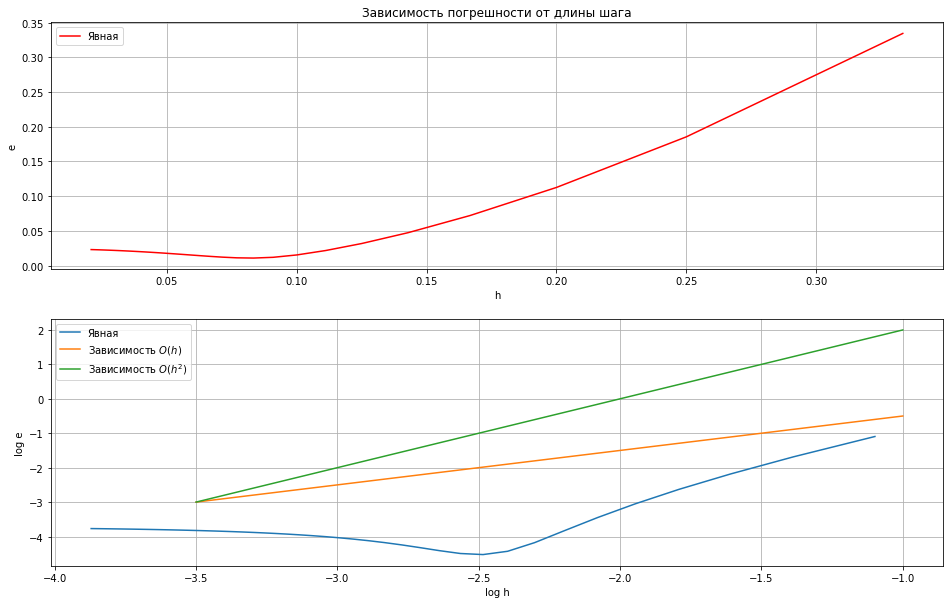

In [13]:
plt.figure(figsize = (16, 10))

plt.subplot(2, 1, 1)
plt.title("Зависимость погрешности от длины шага")
h, e = get_graphic_h(explict, u)

plt.plot(h, e, label="Явная", color = "red")
plt.xlabel("h")
plt.ylabel("e")
# plt.ylim([0, 2.1])
# plt.xticks(list(explict.nparange(0, 1.6, 0.1)))
# plt.yticks(list(explict.nparange(0, 2.1, 0.2)))
plt.legend()
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(list(map(math.log, h)), list(map(math.log, e)), label="Явная")
plt.plot([-3.5, -1], [-3, -0.5], label="Зависимость $O(h)$")
plt.plot([-3.5, -1], [-3, 2], label="Зависимость $O(h^2)$")
plt.xlabel("log h")
plt.ylabel("log e")
# plt.ylim([-3, 1])
# plt.xlim([-2.1, 0.5])
# plt.xticks(list(explict.nparange(-2, 0.5, 0.1)))
# plt.yticks(list(explict.nparange(-3, 1, 0.2)))
plt.legend()
plt.grid()

#### Неявная схема

In [14]:
# Krank Nikolson with O = 1 is implict schema
implict = Implict_Schema(T = 1, aprx_cls=approx_two_two)

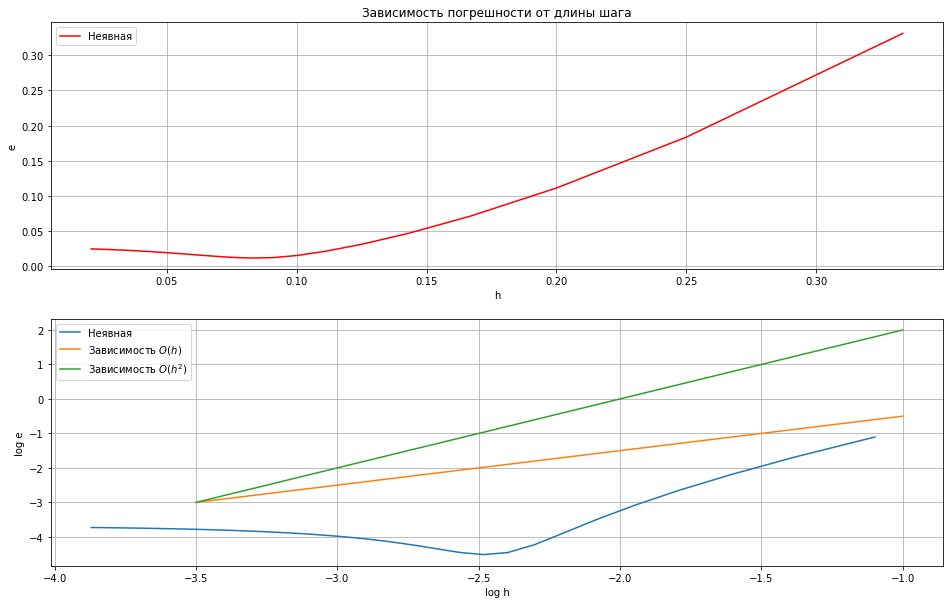

In [15]:
plt.figure(figsize = (16, 10))

plt.subplot(2, 1, 1)
plt.title("Зависимость погрешности от длины шага")
h, e = get_graphic_h(implict, u)

plt.plot(h, e, label="Неявная", color = "red")
plt.xlabel("h")
plt.ylabel("e")
# plt.ylim([0, 2.1])
# plt.xticks(list(implict.nparange(0, 1.6, 0.1)))
# plt.yticks(list(implict.nparange(0, 2.1, 0.2)))
plt.legend()
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(list(map(math.log, h)), list(map(math.log, e)), label="Неявная")
plt.plot([-3.5, -1], [-3, -0.5], label="Зависимость $O(h)$")
plt.plot([-3.5, -1], [-3, 2], label="Зависимость $O(h^2)$")
plt.xlabel("log h")
plt.ylabel("log e")
# plt.ylim([-3, 1])
# plt.xlim([-2, 0.5])
# plt.xticks(list(implict.nparange(-2, 0.5, 0.1)))
# plt.yticks(list(implict.nparange(-3, 1, 0.2)))
plt.legend()
plt.grid()

<h3><center> Зависимость погрешности от параметра $\tau$ </center></h3>

#### Вычисление погрешности

Построение зависимости погрешности от параметра $\tau$.

In [16]:
def get_graphic_tau(solver, real_f):
    tau = []
    e = []
    for K in range(3, 90):
        x, y, z = solver(K = K)
        tau.append(solver.tau)
        e.append(epsilon(x, y, z, real_f))
    return tau, e

#### Явная схема

In [17]:
explict = Explict_Schema(T = 1, aprx_cls=approx_two_two)

<ipython-input-4-5ffb4a1b1180>:5: UserWarning: Sigma > 1
  warnings.warn("Sigma > 1")


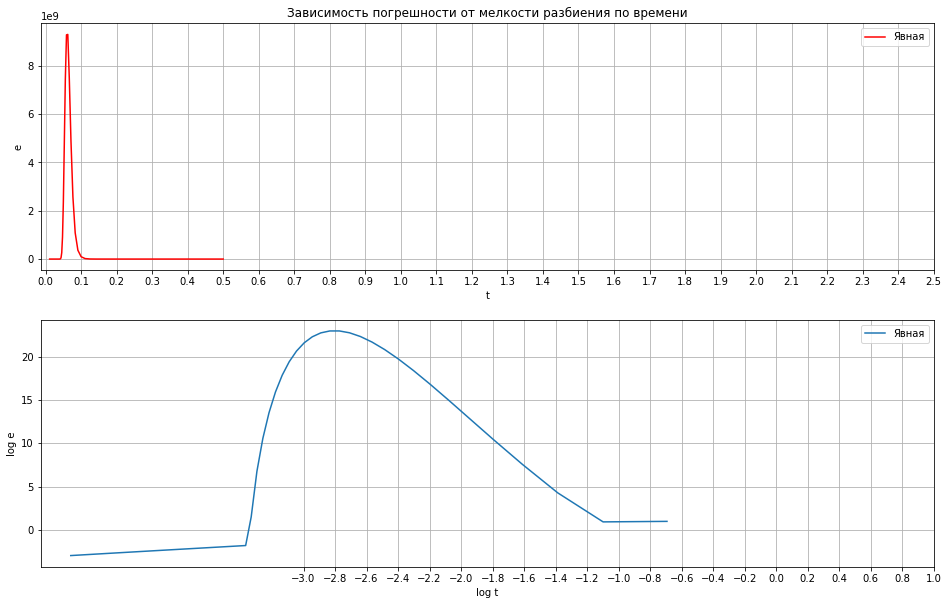

In [18]:
plt.figure(figsize = (16, 10))

plt.subplot(2, 1, 1)
plt.title("Зависимость погрешности от мелкости разбиения по времени")
tau, e = get_graphic_tau(explict, u)

plt.plot(tau, e, label="Явная", color = "red")
plt.xlabel("t")
plt.ylabel("e")
# plt.ylim([0, 2.1])
plt.xticks(list(explict.nparange(0, 2.5, 0.1)))
# plt.yticks(list(explict.nparange(0, 2.1, 0.2)))
plt.legend()
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(list(map(math.log, tau)), list(map(math.log, e)), label="Явная")
plt.xlabel("log t")
plt.ylabel("log e")
# plt.ylim([-3, 1])
# plt.xlim([-2, 0.5])
plt.xticks(list(explict.nparange(-3, 1, 0.2)))
# plt.yticks(list(explict.nparange(-3, 1, 0.2)))
plt.legend()
plt.grid()

#### Неявная схема

In [19]:
# Krank Nikolson with O = 1 is implict schema
implict = Implict_Schema(T = 1, aprx_cls=approx_two_two, order2nd=True)

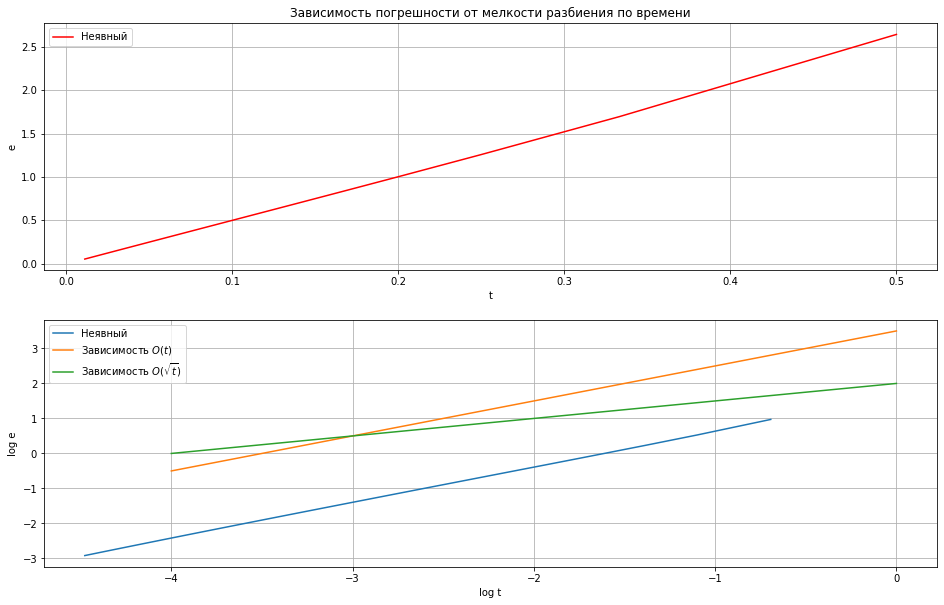

In [20]:
plt.figure(figsize = (16, 10))

plt.subplot(2, 1, 1)
plt.title("Зависимость погрешности от мелкости разбиения по времени")
tau, e = get_graphic_tau(implict, u)

plt.plot(tau, e, label="Неявный", color = "red")
plt.xlabel("t")
plt.ylabel("e")
# plt.ylim([0, 2.1])
# plt.xticks(list(explict.nparange(0, 2.5, 0.1)))
# plt.yticks(list(implict.nparange(0, 2.1, 0.2)))
plt.legend()
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(list(map(math.log, tau)), list(map(math.log, e)), label="Неявный")
plt.plot([-4, 0], [-0.5, 3.5], label="Зависимость $O(t)$")
plt.plot([-4, 0], [0, 2], label="Зависимость $O(\sqrt{t})$")
plt.xlabel("log t")
plt.ylabel("log e")
# plt.ylim([-3, 1])
# plt.xlim([-2, 0.5])
# plt.xticks(list(explict.nparange(-3, 1, 0.2)))
# plt.yticks(list(implict.nparange(-3, 1, 0.2)))

plt.legend()
plt.grid()

<h3><center> Графическая иллюстрация </center></h3>

#### Сетка для реальной функции

In [21]:
def real_z(l0, l1, T, f):
    x = np.arange(l0, l1 + 0.002, 0.002)
    y = np.arange(0, T + 0.002, 0.002)
    X = np.ones((y.shape[0], x.shape[0]))
    Y = np.ones((x.shape[0], y.shape[0]))
    Z = np.ones((y.shape[0], x.shape[0]))
    for i in range(Y.shape[0]):
        Y[i] = y
    Y = Y.T
    for i in range(X.shape[0]):
        X[i] = x
    for i in range(Z.shape[0]):
        for j in range(Z.shape[1]):
            Z[i, j] = f(X[i, j], Y[i, j])
    return X, Y, Z

#### Явная схема

In [22]:
def plot_1(n = 5, k=10, t=1, plot = False):
    schema = Explict_Schema(T = t, aprx_cls=approx_two_two)
    x, y, z = schema(N = n, K = k)
    fig = plt.figure(num=1, figsize=(19, 12), clear=True)
    ax = fig.add_subplot(1, 1, 1, projection='3d')
    if plot:
        ax.plot_wireframe(*real_z(0, 1, t, u), color="green")
    ax.plot_surface(np.array(x), np.array(y), np.array(z))
    ax.set(xlabel='x', ylabel='t', zlabel='z', title='График приближения и реальной функции явным методом')
    fig.tight_layout()

interact(plot_1, n=(4, 200, 2), k=(5, 200, 3), t = (1, 10, 1), plot_true = [False, True])
None

interactive(children=(IntSlider(value=5, description='n', max=200, min=4, step=2), IntSlider(value=10, descrip…

#### Неявная схема

In [23]:
def plot_2(n = 5, k=10, t=1, plot = False):
    schema = Implict_Schema(T = t, aprx_cls=approx_two_two)
    x, y, z = schema(N = n, K = k)
    fig = plt.figure(num=1, figsize=(19, 12), clear=True)
    ax = fig.add_subplot(1, 1, 1, projection='3d')
    if plot:
        ax.plot_wireframe(*real_z(0, 1, t, u), color="green")
    ax.plot_surface(np.array(x), np.array(y), np.array(z))
    ax.set(xlabel='x', ylabel='t', zlabel='z', title='График приближения и реальной функции неявным методом')
    fig.tight_layout()

interact(plot_2, n=(4, 200, 2), k=(5, 200, 3), t = (1, 10, 1), plot_true = [False, True])
None

interactive(children=(IntSlider(value=5, description='n', max=200, min=4, step=2), IntSlider(value=10, descrip…

###### <center>Сделано Бронниковым Максимом</center>
###### <center>15.09.2020</center>